## **Predicting the Likelihood of Injury in Sports Players**

---

> **Objective:**
- The primary goal of this notebook is to build a classification model that helps safeguard athletes' health by predicting the likelihood of injuries. The model will leverage various factors, including height, weight, history of previous injuries, recovery time, and training intensity, among others, to assess the risk of injury.


### <font color=#20a0ff> <b>Project Overview: Player Injury Prediction Using ANN</b> </font>

This project focuses on developing a **predictive** model to predict the **likelihood of injury** in athletes based on key physical and performance indicators.  

The goal is to proactively identify players at high risk of injury, allowing coaches, trainers, and medical staff to tailor training loads and recovery strategies to minimize downtime and improve athlete longevity.

---

### <font color=#20a0ff> <b>Importance of Injury Prediction in Sports</b> </font>

Injury prevention is crucial in professional sports, where even a minor injury can disrupt team performance and an athlete’s career trajectory.  
By predicting injury likelihood, teams can:
- Optimize training and recovery plans
- Reduce costly absences from games
- Improve overall team performance
- Prolong player careers through better load management

---

### <font color=#20a0ff> <b>Key Steps in the Project</b> </font>

Before training the **predictive model**, several steps were taken to ensure the data is clean, relevant, and suitable for learning:

1. **Data Cleaning**: Removing or correcting missing values, outliers, and inconsistencies to maintain data integrity.
2. **Feature Scaling**: Normalizing values such as **Weight**, **Height**, and **Recovery_Time** to improve model convergence and performance.
3. **Exploratory Data Analysis (EDA)**: Understanding feature distributions and relationships—e.g., how **Previous_Injuries** correlate with **Likelihood_of_Injury**.
4. **Model Development (ANN)**: Develop a model to capture complex, non-linear relationships between player metrics and injury risk.
5. **Model Evaluation**: Using metrics like accuracy, precision, recall, and F1-score to assess prediction quality.
6. **Actionable Insights**: Identifying risk patterns that can inform training modifications and preventive care.

---


### <font color=#20a0ff> <b>About the Dataset</b> </font>

The dataset includes biometric and training-related attributes for individual players.  
Each record represents a player profile along with an associated **Likelihood_of_Injury** value, which is the **target** variable.

![Injury.jpg](https://e0.365dm.com/25/03/768x432/skysports-dupont-france_6850655.jpg?20250308185640)


- **Number of Rows:**  1000
- **Number of Columns:** 7

| **No** | **INPUTS**             | **Description**                                                                 |
|--------|------------------------|---------------------------------------------------------------------------------|
| 1      | **Player_Age**         | Age of the player in years.                                                    |
| 2      | **Player_Weight**      | Weight of the player.                                 |
| 3      | **Player_Height**      | Height of the player.                               |
| 4      | **Previous_Injuries**  | Number of past injuries the player has sustained.                              |
| 5      | **Training_Intensity** | Average weekly training intensity or workload level.                           |
| 6      | **Recovery_Time**      | Average time taken by the player to recover after training (in days).    |
| 7      | **Likelihood_of_Injury** | Target variable—predicted probability or classification of injury risk.        |


## Importing Libraries

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from platform import python_version
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import NuSVC
from sklearn.tree import ExtraTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load the Dataset

**To begin with, we will mount our drive.**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Ensure that you place a shortcut to the datasets folder in your drive.**

In [3]:
import os
os.chdir("/content/drive/MyDrive/datasets/")

Now let's proceed to load the dataset of interest: `injury_data.csv`

In [4]:
df = pd.read_csv('injury_data_with_categories.csv')

df.head(5)

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury,Position,Training_Surface
0,24,66.251933,175.732429,1,0.457929,5,0,Midfielder,Artificial Turf
1,37,70.996271,174.581650,0,0.226522,6,1,Forward,Hard Court
2,32,80.093781,186.329618,0,0.613970,2,1,Goalkeeper,Grass
3,28,87.473271,175.504240,1,0.252858,4,1,Midfielder,Grass
4,25,84.659220,190.175012,0,0.577632,1,1,Midfielder,Grass


Let's round up `Player_Weight`, `Player_Height` and `Training_Intensity` to decimal places for consistency.

In [5]:
df['Player_Weight'] = df['Player_Weight'].round(2)
df['Player_Height'] = df['Player_Height'].round(2)
df['Training_Intensity'] = df['Training_Intensity'].round(2)

Let's check for missing values or duplicate rows.

In [6]:
missing_values = df.isnull().sum()
duplicate_rows = df.duplicated().sum()

missing_values, duplicate_rows

(Player_Age              0
 Player_Weight           0
 Player_Height           0
 Previous_Injuries       0
 Training_Intensity      0
 Recovery_Time           0
 Likelihood_of_Injury    0
 Position                0
 Training_Surface        0
 dtype: int64,
 np.int64(0))

There are no missing values nor duplicates.


## Feature Engineering

We will create two new columns: one containing the BMI and the other Age categories.

- The Body Mass Index (BMI) is a measure used to assess whether a person has a healthy weight in relation to their height. It is calculated by dividing weight (in kilograms) by height squared (in meters).

- The mathematical formula for calculating BMI and its classifications are shown in the image below:

  ![BMI-2.jpg](https://mennohenselmans.com/wp-content/uploads/2022/06/bmi-formula.jpg)

- In a real-life scenario, BMI wouldn't be the best indicator to assess whether the athlete is in their best physical condition, as this index doesn't take into account the athlete's body composition. Someone with a more robust physical structure, with greater muscle mass and bone density, may be assessed as overweight, even though they are healthy and have a lower risk of injury. Ideally, we would have data on the body composition of each athlete, as well as the sport they practice. Since we do not have this data, BMI will be used as it is a generalist index.


In [7]:
# Calculate the Body Mass Index (BMI)
df['BMI'] = df['Player_Weight'] / (df['Player_Height'] / 100) ** 2

# Defining gaps for BMI classification
gaps = [-float('inf'), 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')]
categories = ['Underweight', 'Normal', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III']

# Create "BMI_Classification" column | Criar a coluna "Classificação_IMC"
df['BMI_Classification'] = pd.cut(df['BMI'], bins=gaps, labels=categories, right=False)

df.head(1)

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury,Position,Training_Surface,BMI,BMI_Classification
0,24,66.25,175.73,1,0.46,5,0,Midfielder,Artificial Turf,21.453298,Normal


Next, we will create Age categories:

- I chose to group the 1000 players in this dataset into 5 age groups, aiming to visualize these clusters and test the addition of these columns to assess the performance of the models.

In [8]:
# Finding the youngest and oldest age among athletes
print('Player Age Min: {}'.format(df.Player_Age.min()))
print('Player Age Max: {}'.format(df.Player_Age.max()))

Player Age Min: 18
Player Age Max: 39


In [9]:
# Creating columns with grouping
df["Age_Group"] = pd.cut(
    df["Player_Age"],
    bins=[18, 22, 26, 30, 34, df["Player_Age"].max()],
    labels=["18-22", "23-26", "27-30", "31-34", "35+"],
    include_lowest=True,
)

df.head(5)

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury,Position,Training_Surface,BMI,BMI_Classification,Age_Group
0,24,66.25,175.73,1,0.46,5,0,Midfielder,Artificial Turf,21.453298,Normal,23-26
1,37,71.00,174.58,0,0.23,6,1,Forward,Hard Court,23.295357,Normal,35+
2,32,80.09,186.33,0,0.61,2,1,Goalkeeper,Grass,23.068148,Normal,31-34
3,28,87.47,175.50,1,0.25,4,1,Midfielder,Grass,28.399120,Overweight,27-30
4,25,84.66,190.18,0,0.58,1,1,Midfielder,Grass,23.407152,Normal,23-26


## Exploratory Data Analysis



In [10]:
def plot_histogram_kde_and_boxplot(dataframe, column, color_column):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Remove grid and spines
    for ax in axs:
        ax.grid(False)
        for spine in ax.spines.values():
            spine.set_visible(False)

    # Plot histogram (subplot 1)
    sns.histplot(data=dataframe, x=column, bins=20, color='skyblue', edgecolor='black', kde=True, ax=axs[0])

    # Add labels
    axs[0].set_xlabel('')
    axs[0].set_ylabel('')
    axs[0].set_title(f'{column} Histogram', weight='bold', size=13)

    # Plot KDE (subplot 2)
    sns.kdeplot(data=dataframe, x=column, color='skyblue', fill=True, hue=color_column, palette={0: 'green', 1: 'red'}, ax=axs[1])
    axs[1].set_xlabel('')
    axs[1].set_ylabel('')
    axs[1].set_title(f'{column} Density', weight='bold', size=13)

    # Plot boxplot (subplot 3)
    sns.boxplot(data=dataframe[column], orient='h', ax=axs[2])

    # Add labels
    axs[2].set_xlabel('')
    axs[2].set_ylabel('')
    axs[2].set_title(f'{column} Boxplot', weight='bold', size=13)

    # Adjust layout
    plt.tight_layout()

    # Display figure
    plt.show()


def plot_dual_chart(dataframe, column1, column2, cat_order=None, y_limit1=None, y_limit2=None):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    # Remove grid and spines
    for ax in axs:
        ax.grid(False)
        for spine in ax.spines.values():
            spine.set_visible(False)

    # Plot histogram
    sns.histplot(data=dataframe, x=column1, bins=20, color='skyblue', edgecolor='black', kde=True, ax=axs[0])
    axs[0].set_title(f'{column1} Histogram', weight='bold', size=13)
    axs[0].set_xlabel('')
    axs[0].set_ylabel('')

    # Define y limit
    if y_limit1 is None:
        y_limit1 = dataframe[column1].max() * 1.1
    axs[0].set_ylim(top=y_limit1)

    # Plot two sets of bars
    ax = sns.countplot(data=dataframe, x=column2, hue='Likelihood_of_Injury', palette={0: 'green', 1: 'red'}, ax=axs[1], linewidth=2, order=cat_order)

    # Add labels
    axs[1].set_xlabel('')
    axs[1].set_ylabel('')
    axs[1].set_title(f'{column2} x Likelihood_of_Injury', weight='bold', size=13)

    # Rotate x-axis labels
    axs[1].tick_params(axis='x', rotation=0)

    # Remove background grid
    axs[1].grid(False)

    # Add legend
    axs[1].legend()

    # Define upper limit
    if y_limit2 is None:
        y_limit2 = dataframe[column2].value_counts().max() * 1.1  # Max value multiplied by 1.1 to ensure a margin
    axs[1].set_ylim(top=y_limit2)

    # Add values on top of each bar
    for p in axs[1].patches:
        height = p.get_height()
        if not np.isnan(height):
            axs[1].annotate(str(int(height)), (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points', color='black', weight='bold', size=13)
        else:
            axs[1].annotate("0", (p.get_x() + p.get_width() / 2., 0),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points', color='black', weight='bold', size=13)

    # Adjust layout
    plt.tight_layout()

    # Display figure
    plt.show()



### Age_Group

- We can observe an increase in the proportion of players with injury probability in the age range of 27 to 30 years, compared to the other groups.

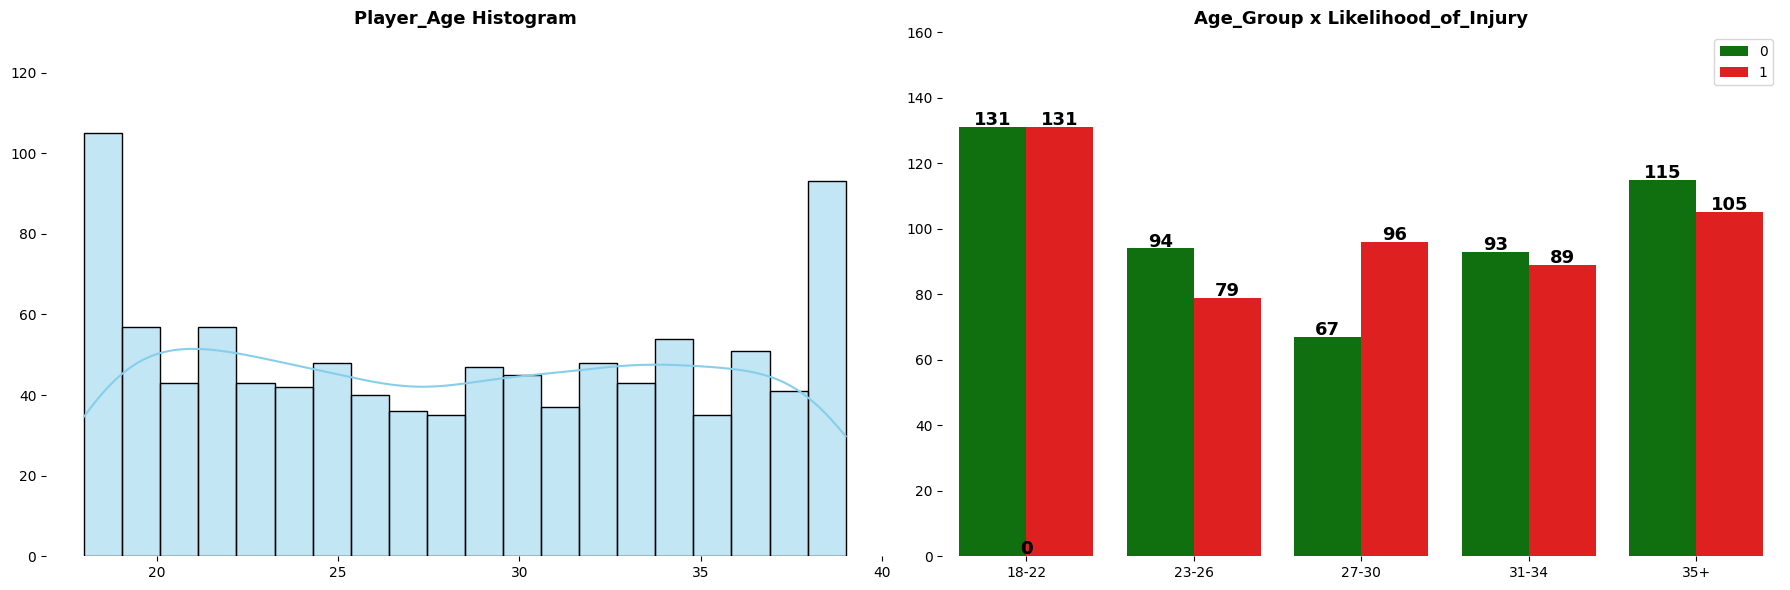

In [11]:
plot_dual_chart(df, 'Player_Age', 'Age_Group', cat_order=["18-22", "23-26", "27-30", "31-34", "35+"], y_limit1=130, y_limit2=160)

### BMI_Classification

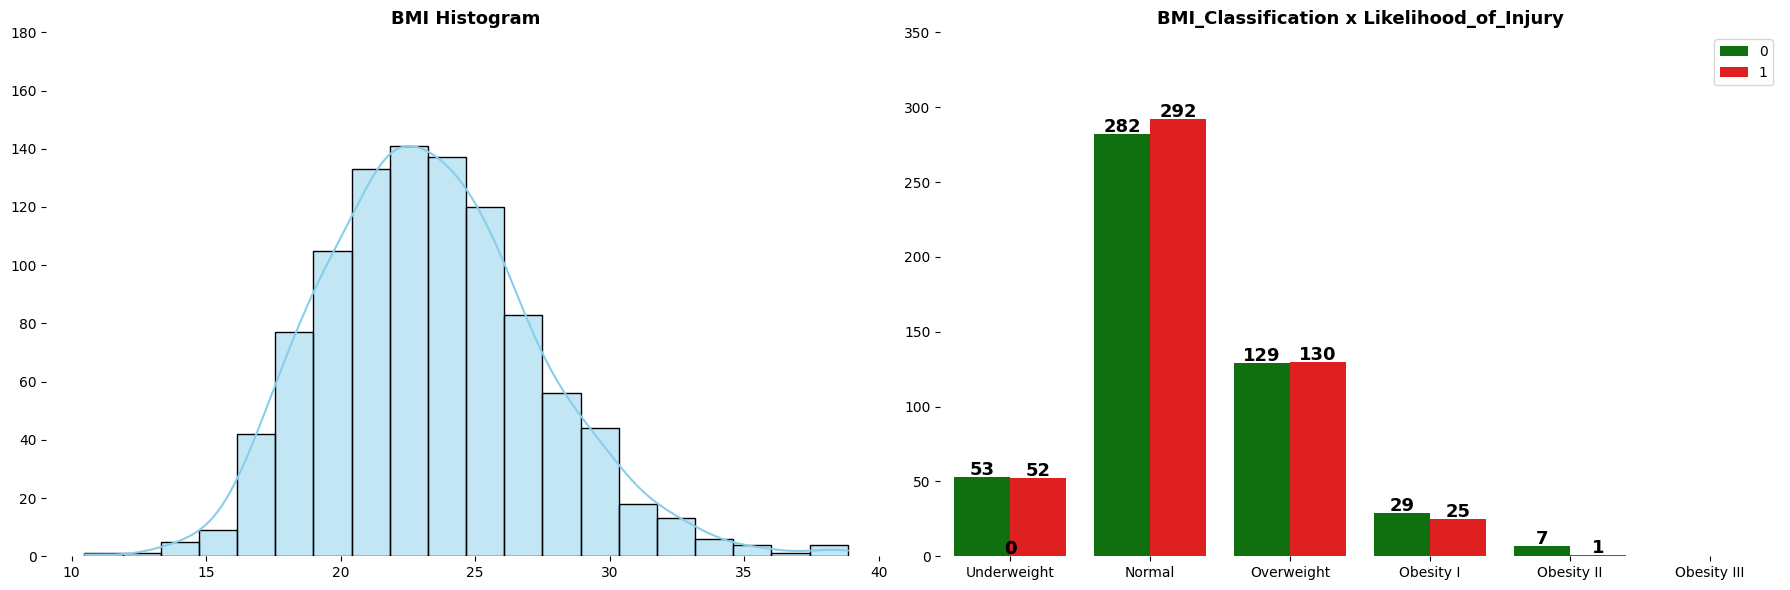

In [12]:
plot_dual_chart(df, 'BMI', 'BMI_Classification', y_limit1=180, y_limit2=350)

### Player_Weight

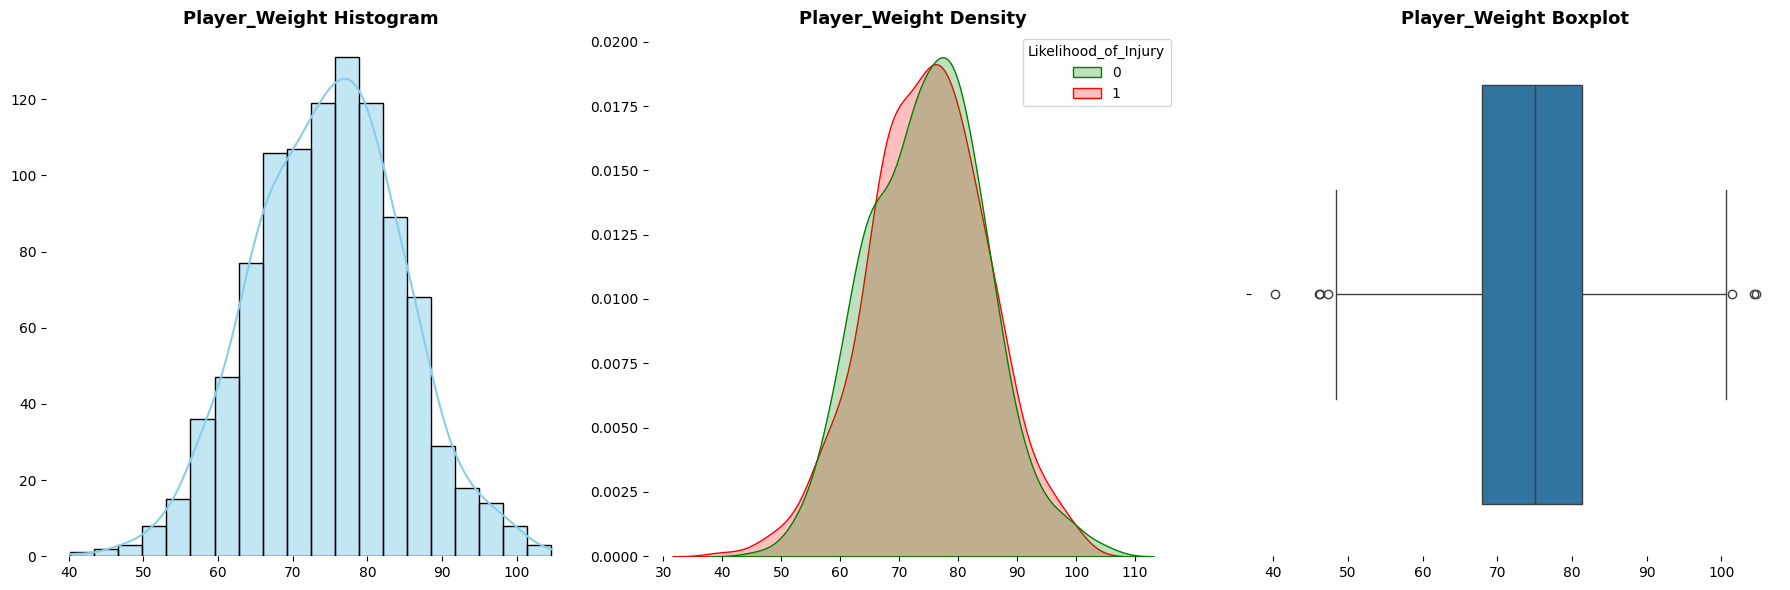

In [13]:
plot_histogram_kde_and_boxplot(df, 'Player_Weight', 'Likelihood_of_Injury')

### Player_Height

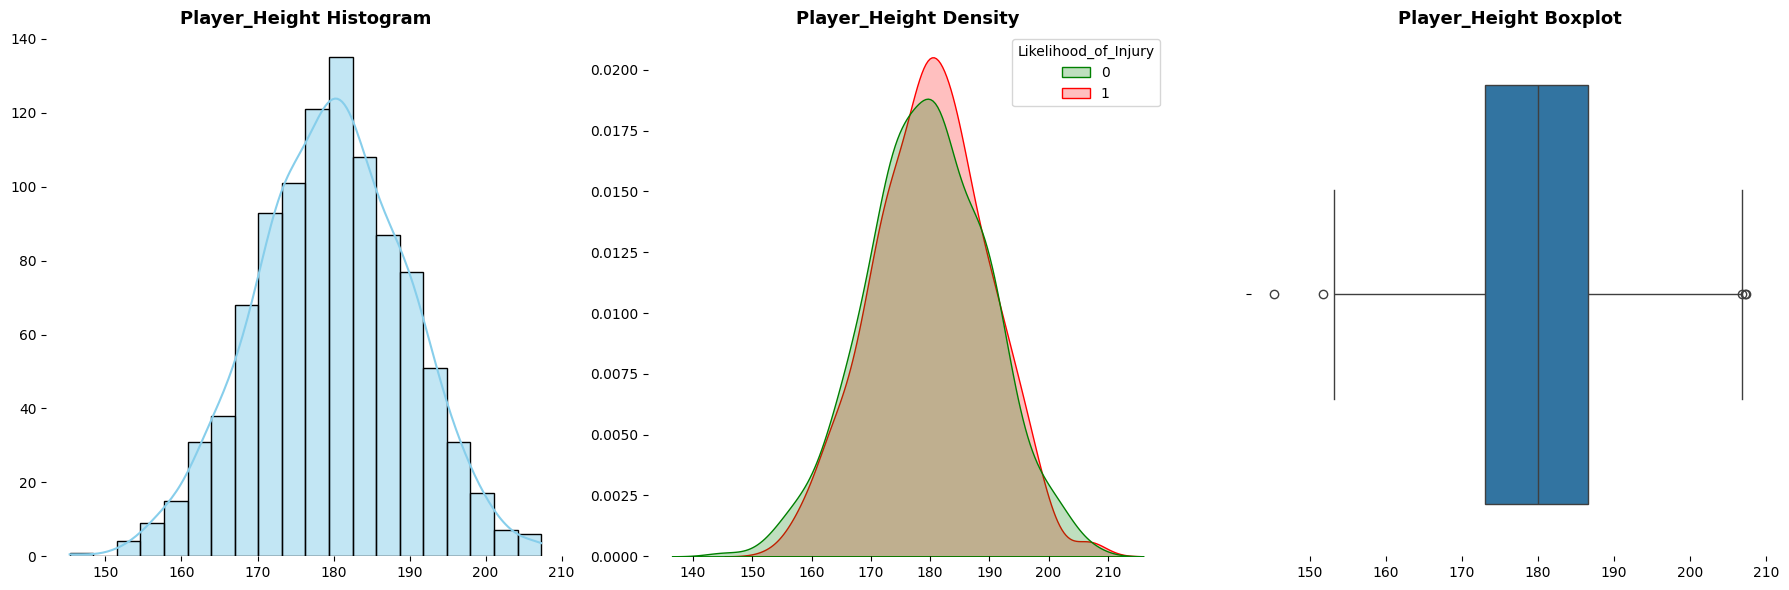

In [14]:
plot_histogram_kde_and_boxplot(df, 'Player_Height', 'Likelihood_of_Injury')

### Training_Intensity

- We can observe that the patterns of injury probability invert in the density plot. In training sessions with lower intensity, the number of players without risk of injury exceeds the number of players at risk, while in training sessions with higher intensity, the number of players at risk of injury surpasses those without risk.


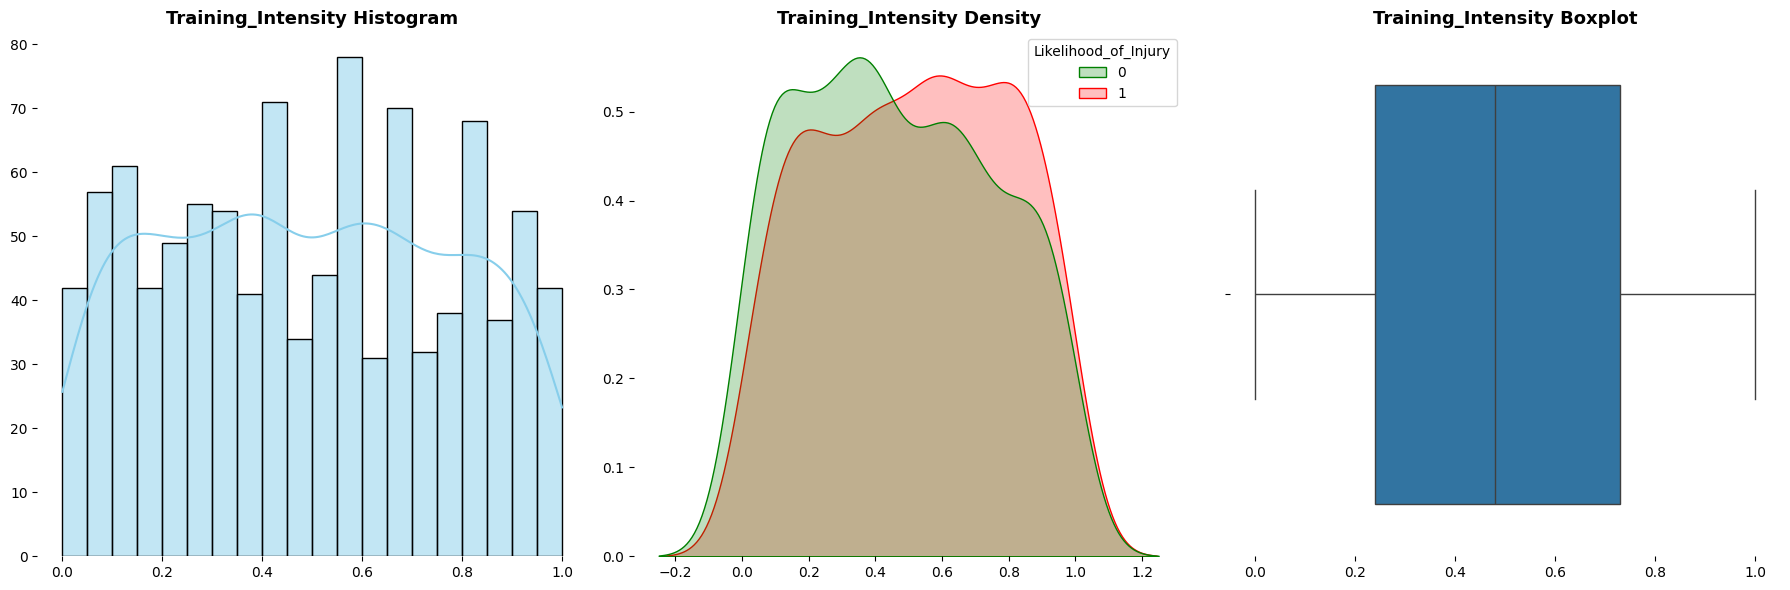

In [15]:
plot_histogram_kde_and_boxplot(df, 'Training_Intensity', 'Likelihood_of_Injury')

### Recovery_Time

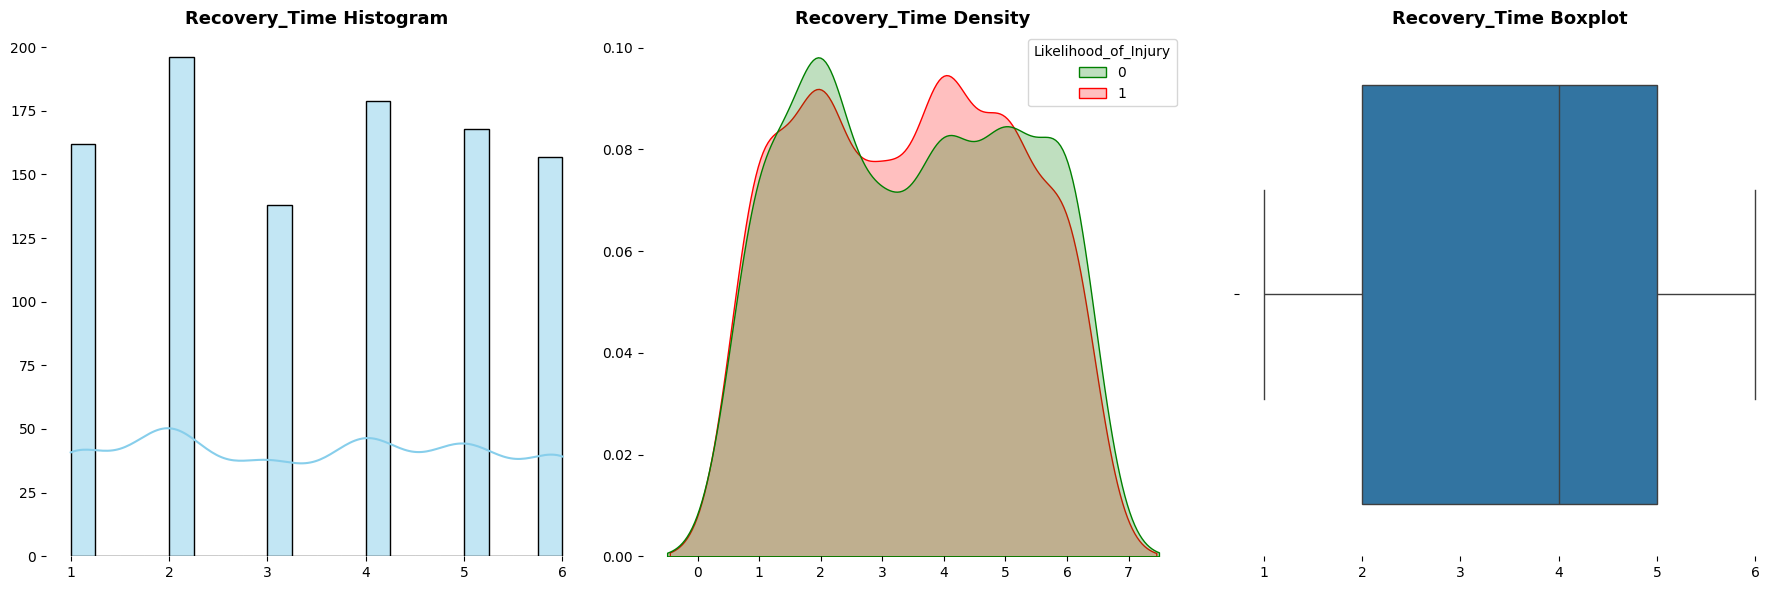

In [16]:
plot_histogram_kde_and_boxplot(df, 'Recovery_Time', 'Likelihood_of_Injury')

### Previous_Injuries

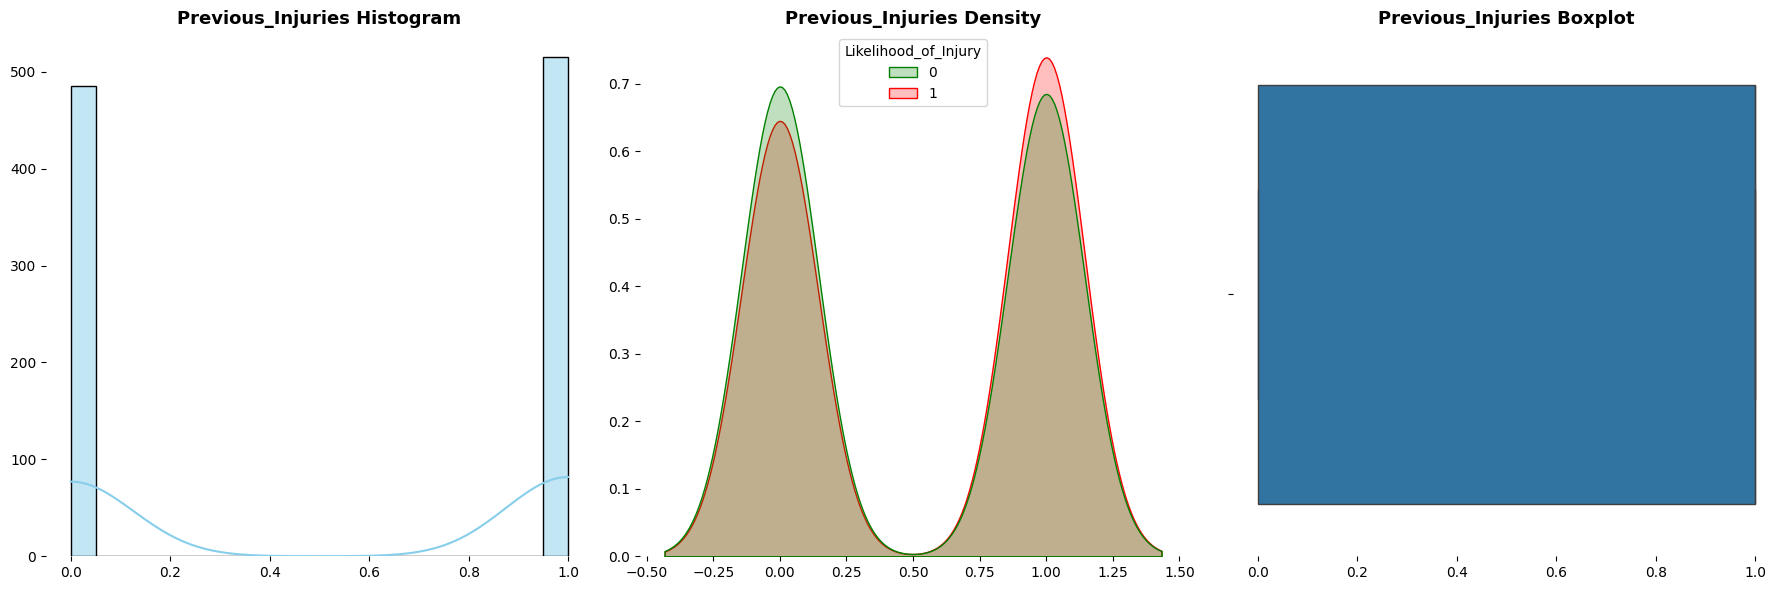

In [17]:
plot_histogram_kde_and_boxplot(df, 'Previous_Injuries', 'Likelihood_of_Injury')

### Likelihood_of_Injury

- Our target column, Likelihood_of_Injury, displays a perfectly balanced data distribution. This means that there's no need to adjust the amount of data during the training process to ensure an adequate distribution between classes 1 and 0.



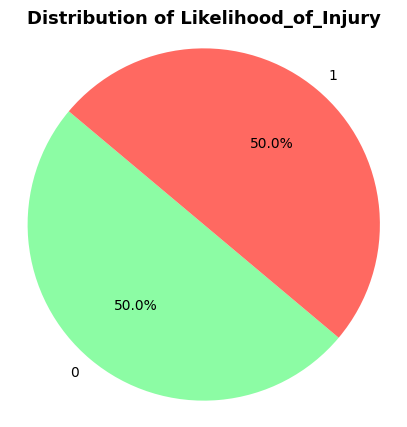

In [18]:
# Count 'Likelihood_of_Injury'
li_count = df['Likelihood_of_Injury'].value_counts()

# Plot pie chart
plt.figure(figsize=(5, 5))
plt.pie(li_count, labels=li_count.index, autopct='%1.1f%%', startangle=140, colors=['#8CFCA4', '#FF6961'])
plt.title('Distribution of Likelihood_of_Injury', weight='bold', size=13)
plt.axis('equal')
plt.show()

## Data Preprocessing


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Step 1: Split your data first
X = df.drop(columns=["Likelihood_of_Injury"])  # Features
y = df["Likelihood_of_Injury"]  # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 2: Select categorical columns to encode
one_hot_cols = ["BMI_Classification", "Age_Group","Training_Surface", "Position"]

# Step 3: Apply OneHotEncoder on training categorical columns only
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train[one_hot_cols])

# Step 4: Apply the same encoder to transform the test set
X_test_encoded = encoder.transform(X_test[one_hot_cols])

# Step 5: Get encoded feature names
encoded_feature_names = encoder.get_feature_names_out(one_hot_cols)

# Step 6: Convert to DataFrames
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)

# Step 7: Drop original categorical columns from X
X_train_clean = X_train.drop(columns=one_hot_cols)
X_test_clean = X_test.drop(columns=one_hot_cols)

# Step 8: Concatenate encoded columns with remaining features
X_train_final = pd.concat([X_train_clean, X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test_clean, X_test_encoded_df], axis=1)


In [20]:
import pickle

# Save the encoder to a pickle file
with open("one_hot_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

In [23]:
X_train_final.head()

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,BMI,BMI_Classification_Normal,BMI_Classification_Obesity I,BMI_Classification_Obesity II,...,Age_Group_27-30,Age_Group_31-34,Age_Group_35+,Training_Surface_Artificial Turf,Training_Surface_Grass,Training_Surface_Hard Court,Position_Defender,Position_Forward,Position_Goalkeeper,Position_Midfielder
29,32,51.75,172.32,1,0.53,6,17.427656,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
535,29,77.97,182.56,0,0.80,3,23.394635,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
695,22,82.08,162.80,0,0.73,3,30.969097,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
557,34,71.96,170.06,0,0.16,2,24.882087,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
836,24,69.05,195.68,1,0.25,1,18.033117,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### Scaling

In [27]:
from sklearn.preprocessing import StandardScaler
import pickle

# Features to scale
scale_cols = ['Player_Age', 'Player_Weight', 'Player_Height', 'Previous_Injuries',
              'Training_Intensity', 'Recovery_Time']

# Initialize scaler
scaler = StandardScaler()

# Fit on training data, transform both train and test
X_train_scaled = scaler.fit_transform(X_train_final[scale_cols])
X_test_scaled = scaler.transform(X_test_final[scale_cols])

# Replace scaled columns in X_train_final and X_test_final
X_train_final[scale_cols] = X_train_scaled
X_test_final[scale_cols] = X_test_scaled

# Save the scaler as a pickle file
with open("standard_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


### Correlation Between Columns <span style="color:#275317">

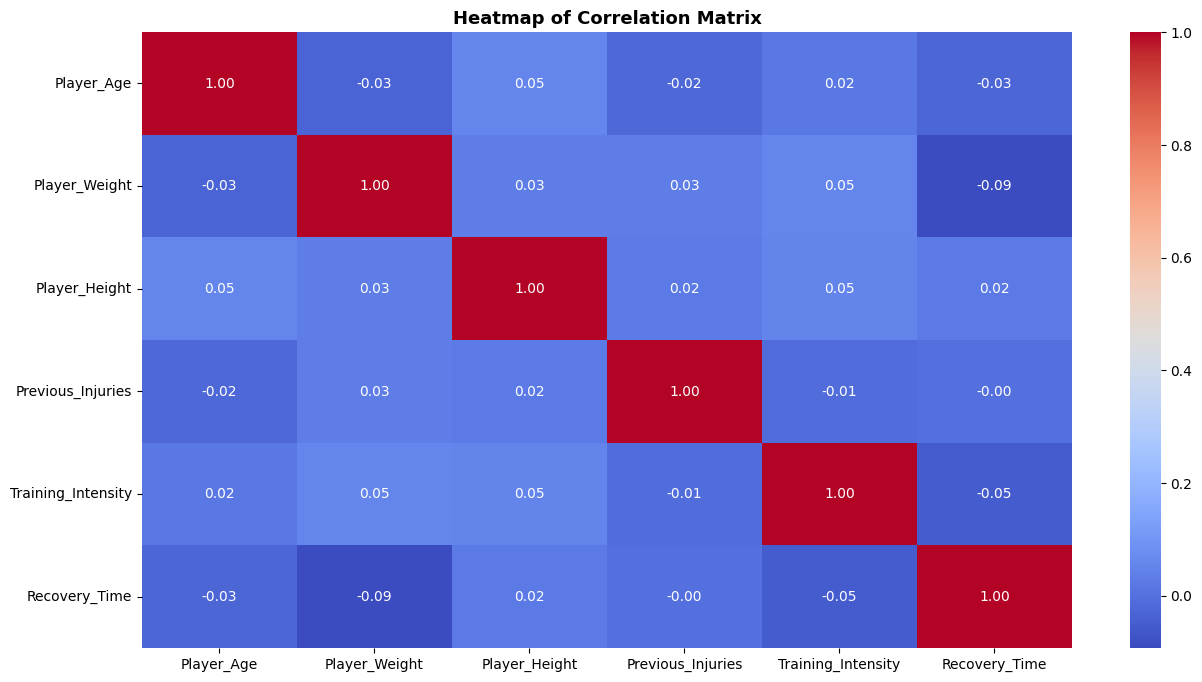

In [28]:
# Calculating correlation matrix
correlation_matrix = X_train_final[['Player_Age', 'Player_Weight', 'Player_Height', 'Previous_Injuries',
       'Training_Intensity', 'Recovery_Time']].corr()

# Plotting heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Correlation Matrix', weight='bold', size=13)
plt.show()


## Training Models <span style="color:#275317">

In [29]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.2 MB/s eta 0:00:00


### **Define the Objective Function:**

In [34]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score


# define a stratified split
skf = StratifiedKFold(n_splits=5,random_state=67, shuffle=True)

# Objective function to optimize
def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['log2', 'sqrt'])

    # Create a Random Forest model with the trial hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Perform cross-validation and return the mean auc
    score = cross_val_score(model, X_train_final, y_train, cv=skf, scoring='roc_auc').mean()

    return score


### **Run the Optimization Process:**

In [35]:
# Create Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30) # Runs 30 trials

[I 2025-03-28 16:22:36,299] A new study created in memory with name: no-name-985530c3-3ee7-4301-8db6-3fb9438bffe0
[I 2025-03-28 16:22:40,054] Trial 0 finished with value: 0.4914830442256603 and parameters: {'n_estimators': 305, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.4914830442256603.
[I 2025-03-28 16:22:44,262] Trial 1 finished with value: 0.483638068448195 and parameters: {'n_estimators': 430, 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.4914830442256603.
[I 2025-03-28 16:22:46,887] Trial 2 finished with value: 0.48732614471011104 and parameters: {'n_estimators': 295, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.4914830442256603.
[I 2025-03-28 16:22:48,011] Trial 3 finished with value: 0.491295514924207 and parameters: {'n_estimators': 123, 'max_depth': 4, 'min_

### **Analyze the Results:**

In [36]:
# Get best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best CV score:", study.best_value)

# Visualization
optuna.visualization.plot_optimization_history(study)

Best hyperparameters:  {'n_estimators': 172, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 17, 'max_features': 'sqrt'}
Best CV score: 0.4962337865291452


In [38]:

optuna.visualization.plot_param_importances(study)

### Confusion Matrix <span style="color:#275317">



In [39]:
# Train model with best hyperparameters
best_model = RandomForestClassifier(**study.best_params, random_state=42)
best_model.fit(X_train_final, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=17, min_samples_split=14,
                       n_estimators=172, random_state=42)

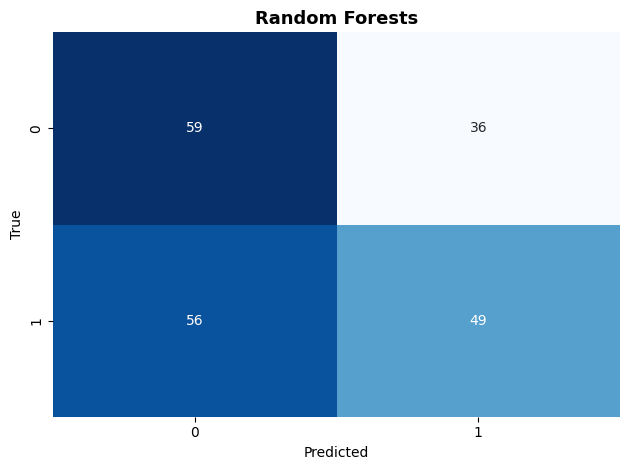

In [44]:
predictions = best_model.predict(X_test_final)
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Random Forests", weight='bold', size=13)
plt.xlabel("Predicted")
plt.ylabel("True")

# Adjust layout and show figure
plt.tight_layout()
plt.show()

### Inverted ROC Curve

- The inverted ROC curve is useful when the analysis focuses on the negative class rather than the positive class. It provides insight into the model's ability to avoid misclassifying negative instances.


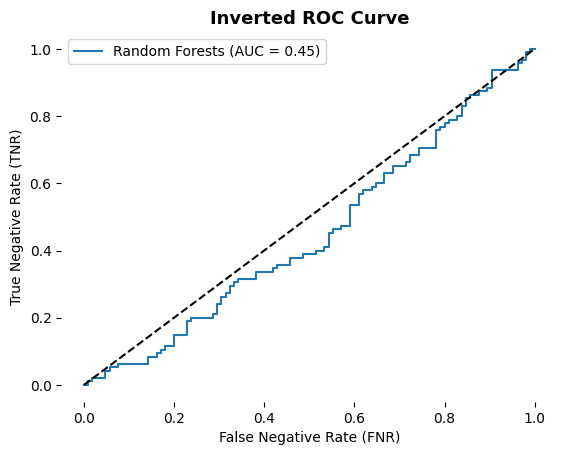

In [46]:
# Plot Inverted ROC Curve

y_proba = best_model.predict_proba(X_test_final)[:, 0]  # Probabilities of belonging to the negative class
fpr, tpr, _ = roc_curve(y_test, y_proba)

tnr = 1 - fpr  # True Negative Rate (TNR)
fnr = 1 - tpr  # False Negative Rate (FNR)

auc = roc_auc_score(y_test, y_proba)
plt.plot(fnr, tnr, label=f'Random Forests (AUC = {auc:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.xlabel('False Negative Rate (FNR)')
plt.ylabel('True Negative Rate (TNR)')
plt.title('Inverted ROC Curve', weight='bold', size=13)
plt.legend()

plt.box(False)  # Remove plot borders
plt.show()

### Save the Model

In [ ]:
import pickle
from sklearn.ensemble import RandomForestClassifier

# 1. Train your Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_final, y_train)

# 2. Save the trained model as a .pkl file
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(model, f)


**Extra: How load saved pickle files**

In [ ]:
with open("random_forest_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# Make predictions
preds = loaded_model.predict(new_samples)


In [ ]:
with open("standard_scaler.pkl", "rb") as f:
    loaded_scaler = pickle.load(f)

# Then use it like this:
scaled_data = loaded_scaler.transform(new_data[scale_cols])


In [ ]:
with open("one_hot_encoder.pkl", "rb") as f:
    loaded_encoder = pickle.load(f)

# Then use it like this:
X_new_encoded = loaded_encoder.transform(new_data[one_hot_cols])
